# FVM Fluid

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/mesh/FVM_Fluid.ipynb)

This example shows how to run a fluid simulation on an unstructured mesh.

In [1]:
%pip install --quiet phiflow
from phi.torch.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange

<Figure size 864x360 with 1 Axes>

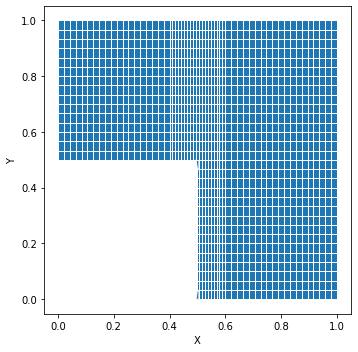

In [2]:
obstacle = Box(x=.5, y=.5)
vert_x = concat([
    math.linspace(0, .4, spatial(x=20))[:-1],
    math.linspace(.4, .6, spatial(x=20))[:-1],
    math.linspace(.6, 1, spatial(x=20)),
    ], 'x')
vert_y = math.linspace(0, 1, spatial(y=31))
mesh = geom.build_mesh(x=vert_x, y=vert_y, obstacles=obstacle)
plot(mesh)

In [3]:
@jit_compile_linear
def momentum_eq(u, u_prev, dt, diffusivity=0.01):
    diffusion_term = dt * diffuse.differential(u, diffusivity, correct_skew=False)
    advection_term = dt * advect.differential(u, u_prev, order=1)
    return u + advection_term + diffusion_term

@jit_compile
def implicit_time_step(v, dt):
    v = math.solve_linear(momentum_eq, v, Solve(x0=v), u_prev=v, dt=-dt)
    v, p = fluid.make_incompressible(v)
    return v

In [ ]:
boundary = {'x-': vec(x=.1, y=0), 'obstacle': 0, 'y': 0, 'x+': ZERO_GRADIENT}
velocity = Field(mesh, tensor(vec(x=0, y=0)), boundary)
v_trj = math.iterate(implicit_time_step, batch(time=100), velocity, dt=0.001, range=trange)

In [5]:
v_trj_grid = v_trj.at(geom.UniformGrid(x=64, y=64, bounds=Box(x=1, y=1)), keep_boundary=True)
plot(v_trj.as_points(), v_trj_grid, animate='time')

c:\phd\phiflow2\phiml\phiml\backend\torch\_torch_backend.py:693: UserWarning: index_reduce() is in beta and the API may change at any time. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cuda\Indexing.cu:1191.)
  result = torch.index_reduce(base_grid, 1, indices[0], values, 'a'+mode)
